# Defining your own mechanisms such as channels and synapses

`neurax` provides an implementation of the standard Hodgkin-Huxley equations and of glutamatergic synapses. In this tutorial, we will explain how you can define your own mechanisms.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# I have experienced stability issues with float32.
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad

import neurax as nx
from neurax.channels import HHChannel
from neurax.synapses import GlutamateSynapse

### Setup

In [4]:
# Number of segments per branch.
nseg_per_branch = 8

# Stimulus.
i_delay = 3.0  # ms
i_amp = 0.05  # nA
i_dur = 2.0  # ms

# Duration and step size.
dt = 0.025  # ms
t_max = 50.0  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

### Define a cell

In [5]:
comp = nx.Compartment()
branch = nx.Branch([comp for _ in range(nseg_per_branch)])
cell = nx.Cell([branch for _ in range(5)], parents=jnp.asarray([-1, 0, 0, 1, 1]))

### Define stimuli and recordings

In [6]:
cell.branch(0).comp(0.0).record()
cell.branch(0).comp(0.0).stimulate(nx.step_current(1.0, 2.0, 0.1, time_vec))

### Your own channel
Below is how you can define your own channel. We will go into detail about individual parts of the code in the next couple of cells.

In [7]:
import jax.numpy as jnp
from neurax.channels import Channel
from neurax.solver_gate import solve_gate_exponential


def exp_update_alpha(x, y):
    return x / (jnp.exp(x / y) - 1.0)

class Potassium(Channel):
    """Potassium channel."""

    channel_params = {"gK_new": 0.06}
    channel_states = {"n_new": 0.1}

    @staticmethod
    def step(u, dt, voltages, params):
        """Return updated HH channel state and current."""
        ns = u["n_new"]
        alpha = 0.01 * exp_update_alpha(-(voltages + 55), 10)
        beta = 0.125 * jnp.exp(-(voltages + 65) / 80)
        new_n = solve_gate_exponential(ns, dt, alpha, beta)

        # Multiply with 1000 to convert Siemens to milli Siemens.
        kd_conds = params["gK_new"] * new_n**4 * 1000  # mS/cm^2

        e_kd = -77.0        
        current = kd_conds * (e_kd - voltages)

        return {"n_new": new_n}, (jnp.zeros_like(current), current)

Let's look at each part of this in detail. 

The below is simply a helper function for the solver of the gate variables:
```python
def exp_update_alpha(x, y):
    return x / (jnp.exp(x / y) - 1.0)
```

Next, we define our channel as a class. It should inherit from the `Channel` class and define `channel_params` and `channel_states`. The keys of the corresponding dictioniaries (`gK_new` and `n_new`) have to be unique. In other words, do not use the same keys for multiple different channels.
```python
class Potassium(Channel):
    """Potassium channel."""

    channel_params = {"gK_new": 0.06}
    channel_states = {"n_new": 0.1}
```

Next, we have the `step()` method, which updates the gating variables and returns the current through this channel:
```python
@staticmethod
def step(u, dt, voltages, params):
    """Return updated HH channel state and current."""
```

The inputs `u` to the `step` method is a dictionary which contains all states that are updated (including states of other channels. Let's get the state of the potassium channel which we are building here:
```python
ns = u["n_new"]
```

Next, we update the state of the channel. In this example, we do this with exponential Euler, but you can implement any solver yourself:
```python
alpha = 0.01 * exp_update_alpha(-(voltages + 55), 10)
beta = 0.125 * jnp.exp(-(voltages + 65) / 80)
new_n = solve_gate_exponential(ns, dt, alpha, beta)
```

We then compute the current through this channel:
```python
# Multiply with 1000 to convert Siemens to milli Siemens.
kd_conds = params["gK_new"] * new_n**4 * 1000  # mS/cm^2

e_kd = -77.0        
current = kd_conds * (e_kd - voltages)
```

Finally, we return the updated state and the current. Please copy the `jnp.zeros_like` to any new channel you are defining. We will remove the need to return this in the future.
```python
return {"n_new": new_n}, (jnp.zeros_like(current), current)
```

Alright, done! We can now insert this channel into any `nx.Module` such as our cell:

In [8]:
cell.insert(Potassium())

In [9]:
s = nx.integrate(cell, delta_t=dt)

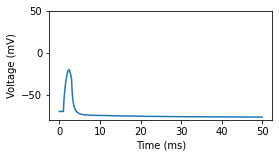

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(time_vec, s.T[:-1])
_ = ax.set_ylim([-80, 50])
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")

### Your own synapse

### Warning: this tutorial will still be revised.

In [11]:
import jax.numpy as jnp
from neurax.synapses.synapse import Synapse


class CholineSynapse(Synapse):
    """
    Compute syanptic current and update syanpse state for Choline receptor.
    """

    synapse_params = {"gChol": 1.0}
    synapse_states = {"s_chol": 0.1}

    @staticmethod
    def step(
        u, delta_t, voltages, params, pre_inds):
        """Return updated synapse state and current."""
        e_syn = 0.0
        v_th = -35.0
        delta = 10.0
        k_minus = 1.0 / 40.0

        s_bar = 1.0 / (1.0 + jnp.exp((v_th - voltages[pre_inds]) / delta))
        tau_s = (1.0 - s_bar) / k_minus

        s_inf = s_bar
        slope = -1.0 / tau_s
        exp_term = jnp.exp(slope * delta_t)
        new_s = u["s_chol"] * exp_term + s_inf * (1.0 - exp_term)

        non_zero_voltage_term = params["gChol"] * u["s_chol"]
        non_zero_constant_term = params["gChol"] * u["s_chol"] * e_syn

        return {"s_chol": new_s}, (non_zero_voltage_term, non_zero_constant_term)


In [12]:
connectivities = [
    nx.Connectivity(
        CholineSynapse,
        [
            nx.Connection(0, 0, 0.0, 1, 0, 0.0),
        ]
    )
]

In [13]:
net = nx.Network([cell for _ in range(3)], connectivities)

In [14]:
net.cell(0).branch(0).comp(0.0).stimulate(nx.step_current(1.0, 2.0, 0.1, time_vec))
for i in range(3):
    net.cell(i).branch(0).comp(0.0).record()

In [15]:
s = nx.integrate(net, delta_t=dt)

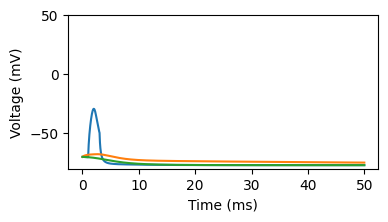

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
_ = ax.plot(time_vec, s.T[:-1])
_ = ax.set_ylim([-80, 50])
_ = ax.set_xlabel("Time (ms)")
_ = ax.set_ylabel("Voltage (mV)")